# Landsat Testing Dataset
## [Using Novelty Detection in Keras with Generative Adversarial Network]

This notebook is for test phase Novelty Detection. To Train the model, run this first.
```bash
python models.py
```

It is recommended to understand how the model works in general before continuing the implementation. 

→ [How to do Novelty Detection in Keras with Generative Adversarial Network (Part 1)](https://www.dlology.com/blog/how-to-do-novelty-detection-in-keras-with-generative-adversarial-network/)


In [73]:
from utils import *
from kh_tools import *
import models
import imp
imp.reload(models)
from models import ALOCC_Model
from keras.datasets import mnist

from keras.losses import binary_crossentropy
from keras import backend as K

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [74]:
self =ALOCC_Model(dataset_name='mnist', input_height=28,input_width=28)

reconstructor
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z (InputLayer)               (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 4, 4, 8)           0      

## Choose a stopping criterion
The training procedure is stopped when R successfully maps noisy images to clean images carrying the concept of the target class.  When R can reconstruct its input with minimum error. In the following case, we pick the epoch 3.

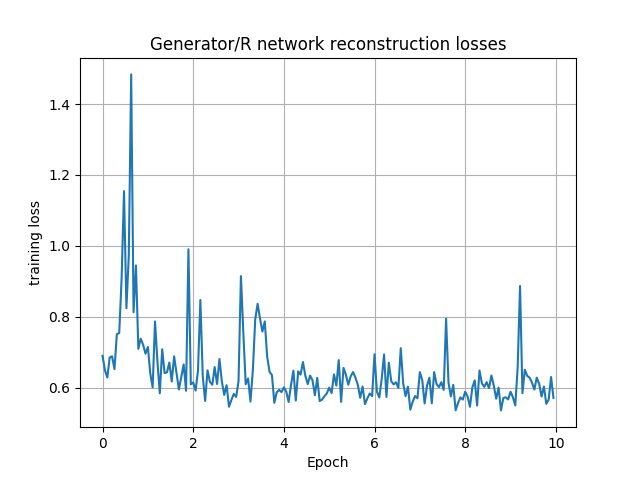

In [77]:
# This image was generated at the end of the models.py training procedure to help pick a ending epoch to load. 
from IPython.display import Image
Image(filename='plot_g_recon_losses.png') 


In [78]:
# Load the epoch #3 saved weights.
self.adversarial_model.load_weights('./checkpoint/ALOCC_Model_9.h5')

In [79]:

#(X_train, y_train), (_, _) = mnist.load_data()
#X_train = X_train / 255

from landsat_data_loader import LandsatDataLoader
root = "/QCOLT/QCOLT_DEV_OPS/"
path = root +'/TDS_NOVELTY_DETECTION/EXP_02//nominal_chips/'    
loader = LandsatDataLoader(path)   
X_train = loader.load_data()
X_train = X_train / 255
#print(X_train.shape)
print("Number of samples loaded =",X_train.shape[0])
print("Dimensions (H,W) = ({},{})".format(X_train.shape[1],X_train.shape[2]))

Number of samples loaded = 9507
Dimensions (H,W) = (28,28)


## Test the reconstruction loss and Discriminator output
The `abnormal` image has a **`larger` reconstruction loss** and **`smaller` discriminator output value**.

In [ ]:

def test_reconstruction(index=0, res_edge = 28):
    data = X_train[index].reshape(-1, res_edge, res_edge, 1)[0:1]
        
    model_predicts = self.adversarial_model.predict(data)
    input_image = data[0].reshape((res_edge, res_edge))
    reconstructed_image = model_predicts[0].reshape((res_edge, res_edge))
    
    y_pred = K.variable(reconstructed_image)
    y_true = K.variable(input_image)
    error = K.eval(binary_crossentropy(y_true, y_pred)).mean()
    print("Index Image:",index,' Reconstruction loss:', error,'Discriminator Output:', model_predicts[1][0][0])
    #print("Model Predicts:",model_predicts)

    montage = np.hstack((input_image,reconstructed_image))

        
    plt.title('Input Image / Reconstructed')
    plt.imshow(montage, label='Input/Recons')
    #fig.add_subplot(rows, columns, 2)
    #plt.title('Reconstruction')
    #plt.imshow(reconstructed_image, label='Reconstructed')
    plt.show()
   

### Normal case
The network was trained with normal samples.

Index Image: 25  Reconstruction loss: 0.57575667 Discriminator Output: 0.33417517
Model Predicts: [array([[[[0.650623  ],
         [0.719995  ],
         [0.72026235],
         [0.74293816],
         [0.73696256],
         [0.72469676],
         [0.7249652 ],
         [0.72467595],
         [0.73540306],
         [0.7359435 ],
         [0.7413429 ],
         [0.76078486],
         [0.7639343 ],
         [0.7663351 ],
         [0.76716846],
         [0.78227293],
         [0.7945638 ],
         [0.8142251 ],
         [0.81022   ],
         [0.8004689 ],
         [0.7868755 ],
         [0.7699959 ],
         [0.76720905],
         [0.74394244],
         [0.7563759 ],
         [0.7771957 ],
         [0.77567923],
         [0.7042643 ]],

        [[0.69975644],
         [0.73545146],
         [0.7351733 ],
         [0.7487908 ],
         [0.76005304],
         [0.7455475 ],
         [0.7453532 ],
         [0.7314514 ],
         [0.75087595],
         [0.74026626],
         [0.7435249 ],
  

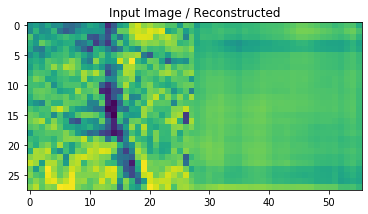

Index Image: 50  Reconstruction loss: 0.6973692 Discriminator Output: 0.3666871
Model Predicts: [array([[[[0.48393604],
         [0.43514618],
         [0.4346181 ],
         [0.43902463],
         [0.43598348],
         [0.43141568],
         [0.44068536],
         [0.45957074],
         [0.47229615],
         [0.4873821 ],
         [0.48688012],
         [0.4950836 ],
         [0.49525833],
         [0.49462944],
         [0.4963963 ],
         [0.5016017 ],
         [0.5081831 ],
         [0.5199588 ],
         [0.5197225 ],
         [0.5142397 ],
         [0.50132346],
         [0.4867125 ],
         [0.48230702],
         [0.4624378 ],
         [0.46318913],
         [0.46462467],
         [0.46754822],
         [0.44686586]],

        [[0.46535143],
         [0.39121455],
         [0.3889761 ],
         [0.3872835 ],
         [0.38489187],
         [0.38406372],
         [0.40140465],
         [0.41919583],
         [0.43964508],
         [0.45224655],
         [0.4494539 ],
    

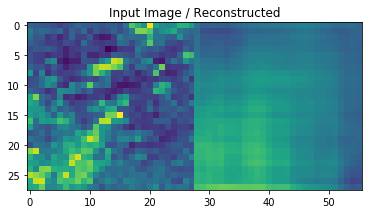

Index Image: 75  Reconstruction loss: 0.67044896 Discriminator Output: 0.33764967
Model Predicts: [array([[[[0.62789917],
         [0.68457776],
         [0.682402  ],
         [0.6956501 ],
         [0.68350136],
         [0.6647945 ],
         [0.6645155 ],
         [0.65923434],
         [0.6701967 ],
         [0.6692683 ],
         [0.66528594],
         [0.6620645 ],
         [0.6375086 ],
         [0.60619503],
         [0.5973988 ],
         [0.5588531 ],
         [0.53733784],
         [0.5022237 ],
         [0.5036211 ],
         [0.49692437],
         [0.4912314 ],
         [0.485311  ],
         [0.47928667],
         [0.45704374],
         [0.46421003],
         [0.48481485],
         [0.49518067],
         [0.46955296]],

        [[0.6690053 ],
         [0.6930766 ],
         [0.6923214 ],
         [0.70237386],
         [0.7063038 ],
         [0.6868883 ],
         [0.68540317],
         [0.6703973 ],
         [0.6779971 ],
         [0.6759238 ],
         [0.6744814 ],
  

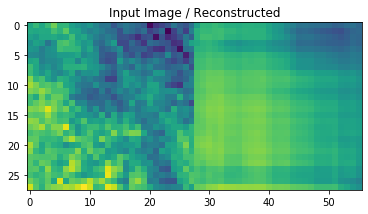

Index Image: 100  Reconstruction loss: 0.6891278 Discriminator Output: 0.3680351
Model Predicts: [array([[[[0.5262616 ],
         [0.5113939 ],
         [0.506531  ],
         [0.50373214],
         [0.49178684],
         [0.47113955],
         [0.47277704],
         [0.4752413 ],
         [0.4821631 ],
         [0.48523182],
         [0.48462114],
         [0.48540762],
         [0.47316137],
         [0.45682195],
         [0.4520638 ],
         [0.4351653 ],
         [0.42712766],
         [0.41424873],
         [0.41397822],
         [0.41242653],
         [0.4146773 ],
         [0.4177834 ],
         [0.41409796],
         [0.4049999 ],
         [0.40612373],
         [0.41066998],
         [0.4116007 ],
         [0.4046805 ]],

        [[0.5274121 ],
         [0.4871813 ],
         [0.47882378],
         [0.4758865 ],
         [0.46809945],
         [0.44702077],
         [0.44805372],
         [0.44640225],
         [0.45089662],
         [0.45301032],
         [0.45373636],
   

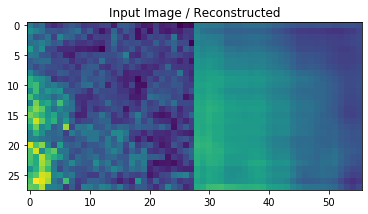

Index Image: 125  Reconstruction loss: 0.69622135 Discriminator Output: 0.3415957
Model Predicts: [array([[[[0.6078336 ],
         [0.6535436 ],
         [0.65334725],
         [0.67263085],
         [0.66760945],
         [0.65671605],
         [0.6562505 ],
         [0.6586569 ],
         [0.6744344 ],
         [0.67926097],
         [0.68192804],
         [0.6942686 ],
         [0.6901452 ],
         [0.6834447 ],
         [0.68311036],
         [0.6814794 ],
         [0.679191  ],
         [0.67856175],
         [0.67570055],
         [0.6629101 ],
         [0.6479994 ],
         [0.62897617],
         [0.6243182 ],
         [0.6004377 ],
         [0.6067161 ],
         [0.623976  ],
         [0.6318593 ],
         [0.58905643]],

        [[0.6461786 ],
         [0.66199064],
         [0.6618094 ],
         [0.67733294],
         [0.69029254],
         [0.6801631 ],
         [0.67991763],
         [0.6676674 ],
         [0.68607104],
         [0.6851748 ],
         [0.68852735],
  

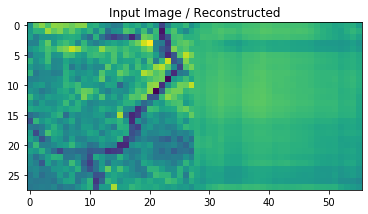

Index Image: 150  Reconstruction loss: 0.6867267 Discriminator Output: 0.36782223
Model Predicts: [array([[[[0.44481274],
         [0.3884231 ],
         [0.3903395 ],
         [0.39507928],
         [0.40063924],
         [0.4106401 ],
         [0.42149854],
         [0.43714803],
         [0.44176447],
         [0.44411075],
         [0.44757643],
         [0.46434903],
         [0.47468546],
         [0.48824453],
         [0.49554214],
         [0.51903576],
         [0.5366946 ],
         [0.562499  ],
         [0.56095505],
         [0.5638662 ],
         [0.559484  ],
         [0.55397236],
         [0.5537016 ],
         [0.5501558 ],
         [0.563683  ],
         [0.59152657],
         [0.5955798 ],
         [0.56146526]],

        [[0.41589552],
         [0.3365511 ],
         [0.33690155],
         [0.340025  ],
         [0.35253075],
         [0.36743265],
         [0.38582107],
         [0.39572445],
         [0.41234916],
         [0.41367924],
         [0.41117164],
  

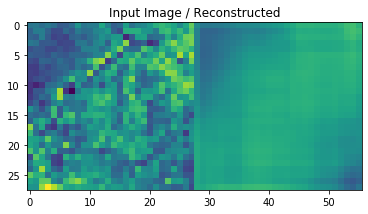

Index Image: 175  Reconstruction loss: 0.6741291 Discriminator Output: 0.37326
Model Predicts: [array([[[[0.4987654 ],
         [0.46645495],
         [0.46744692],
         [0.47064483],
         [0.46115744],
         [0.4488059 ],
         [0.45135552],
         [0.45507473],
         [0.45691705],
         [0.45609114],
         [0.45516276],
         [0.455698  ],
         [0.45150626],
         [0.44447064],
         [0.44195446],
         [0.43727005],
         [0.43559617],
         [0.43277746],
         [0.43122637],
         [0.42893344],
         [0.42859313],
         [0.42834982],
         [0.42576534],
         [0.41881186],
         [0.42047632],
         [0.42363155],
         [0.42320594],
         [0.41381308]],

        [[0.48596025],
         [0.43371937],
         [0.43370155],
         [0.43265936],
         [0.42553872],
         [0.41686583],
         [0.4212719 ],
         [0.41951537],
         [0.42334145],
         [0.41949034],
         [0.4189463 ],
     

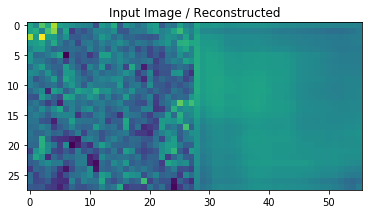

Index Image: 200  Reconstruction loss: 0.67967427 Discriminator Output: 0.3661371
Model Predicts: [array([[[[0.4730621 ],
         [0.42760187],
         [0.42872757],
         [0.42652774],
         [0.42430457],
         [0.42113498],
         [0.42710704],
         [0.44200972],
         [0.45203742],
         [0.46155235],
         [0.4610356 ],
         [0.46490222],
         [0.45860124],
         [0.4495064 ],
         [0.44633907],
         [0.4399295 ],
         [0.4353811 ],
         [0.42585662],
         [0.4224585 ],
         [0.4168883 ],
         [0.41139832],
         [0.4055028 ],
         [0.40106052],
         [0.38846362],
         [0.38691562],
         [0.38720673],
         [0.3856579 ],
         [0.37750956]],

        [[0.45561346],
         [0.38687468],
         [0.38412648],
         [0.37603122],
         [0.37393194],
         [0.3732435 ],
         [0.38616294],
         [0.39898807],
         [0.41359553],
         [0.42733663],
         [0.43226558],
  

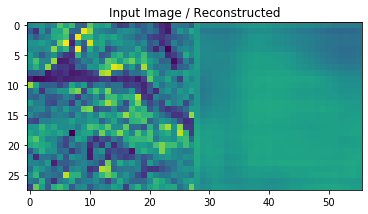

Index Image: 225  Reconstruction loss: 0.63463515 Discriminator Output: 0.39128935
Model Predicts: [array([[[[0.4552432 ],
         [0.40076   ],
         [0.4010464 ],
         [0.40147614],
         [0.39649984],
         [0.3924793 ],
         [0.39382848],
         [0.39500207],
         [0.39557293],
         [0.3936072 ],
         [0.391935  ],
         [0.39030653],
         [0.3862841 ],
         [0.3753909 ],
         [0.37115324],
         [0.35949197],
         [0.35844055],
         [0.35911787],
         [0.3586114 ],
         [0.35438544],
         [0.3502298 ],
         [0.34361613],
         [0.3412304 ],
         [0.32994366],
         [0.32030916],
         [0.30468172],
         [0.29914522],
         [0.30525732]],

        [[0.42725563],
         [0.35013837],
         [0.3502542 ],
         [0.35142666],
         [0.34610814],
         [0.3436604 ],
         [0.34651396],
         [0.34795746],
         [0.34954792],
         [0.3501323 ],
         [0.3510208 ],
 

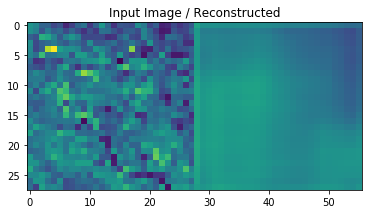

Index Image: 250  Reconstruction loss: 0.43276295 Discriminator Output: 0.37959948
Model Predicts: [array([[[[0.34082142],
         [0.23102215],
         [0.2195279 ],
         [0.19738388],
         [0.18773293],
         [0.17571884],
         [0.17760181],
         [0.18303984],
         [0.18524978],
         [0.18673322],
         [0.18570587],
         [0.17756918],
         [0.17223024],
         [0.16180804],
         [0.15970257],
         [0.15628591],
         [0.1580334 ],
         [0.152448  ],
         [0.15444514],
         [0.16153482],
         [0.17539307],
         [0.19049278],
         [0.19480059],
         [0.2038599 ],
         [0.2166326 ],
         [0.23102823],
         [0.23193839],
         [0.25141063]],

        [[0.28780007],
         [0.16939145],
         [0.16231546],
         [0.13748962],
         [0.12688333],
         [0.11616847],
         [0.11799186],
         [0.12226936],
         [0.12368825],
         [0.12146217],
         [0.11978337],
 

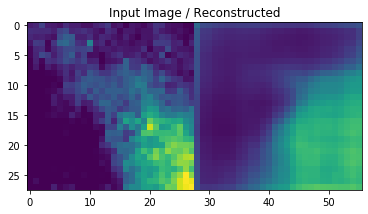

Index Image: 275  Reconstruction loss: 0.63138855 Discriminator Output: 0.37479234
Model Predicts: [array([[[[0.45699334],
         [0.41221595],
         [0.41231698],
         [0.41099402],
         [0.40782535],
         [0.40587276],
         [0.40970665],
         [0.41358578],
         [0.40489954],
         [0.39236742],
         [0.3935114 ],
         [0.39736706],
         [0.41543964],
         [0.44656923],
         [0.46080172],
         [0.4943554 ],
         [0.51036155],
         [0.5301511 ],
         [0.52813584],
         [0.5333051 ],
         [0.53116786],
         [0.5264123 ],
         [0.52563226],
         [0.5160678 ],
         [0.5228592 ],
         [0.53528106],
         [0.5383846 ],
         [0.51295847]],

        [[0.4320411 ],
         [0.36921757],
         [0.36919087],
         [0.37084028],
         [0.36872217],
         [0.36930403],
         [0.37739184],
         [0.3703586 ],
         [0.37008178],
         [0.35477674],
         [0.349949  ],
 

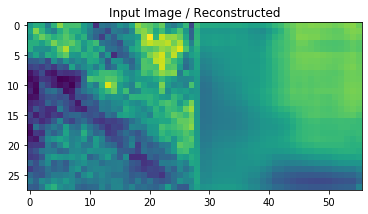

Index Image: 300  Reconstruction loss: 0.6434361 Discriminator Output: 0.33225816
Model Predicts: [array([[[[0.41967115],
         [0.3460124 ],
         [0.34328836],
         [0.33801925],
         [0.3548987 ],
         [0.41341728],
         [0.43956542],
         [0.5212173 ],
         [0.56612897],
         [0.6068694 ],
         [0.60992503],
         [0.6531107 ],
         [0.67464864],
         [0.694102  ],
         [0.69208217],
         [0.70466113],
         [0.73074776],
         [0.75247335],
         [0.74988353],
         [0.74510616],
         [0.71926963],
         [0.6834582 ],
         [0.67642283],
         [0.6398022 ],
         [0.6408247 ],
         [0.6447782 ],
         [0.65145534],
         [0.60026884]],

        [[0.380191  ],
         [0.28967762],
         [0.27736342],
         [0.26758647],
         [0.3097704 ],
         [0.38244173],
         [0.43403995],
         [0.5174382 ],
         [0.58068883],
         [0.62628984],
         [0.6222105 ],
  

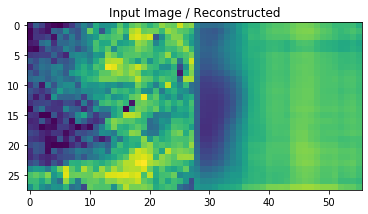

Index Image: 325  Reconstruction loss: 0.6883731 Discriminator Output: 0.33952546
Model Predicts: [array([[[[0.5408323 ],
         [0.537529  ],
         [0.532524  ],
         [0.5418185 ],
         [0.54187226],
         [0.53394246],
         [0.536993  ],
         [0.5464571 ],
         [0.55298394],
         [0.5543967 ],
         [0.55133224],
         [0.5556883 ],
         [0.5547225 ],
         [0.5450003 ],
         [0.5486444 ],
         [0.5662678 ],
         [0.57865644],
         [0.60073316],
         [0.59933084],
         [0.59839535],
         [0.5900748 ],
         [0.58040905],
         [0.5776555 ],
         [0.56042117],
         [0.5736394 ],
         [0.60114974],
         [0.6112139 ],
         [0.5720627 ]],

        [[0.5490929 ],
         [0.5201569 ],
         [0.51161265],
         [0.5179324 ],
         [0.53142047],
         [0.5221773 ],
         [0.5277461 ],
         [0.5283254 ],
         [0.5454088 ],
         [0.5385622 ],
         [0.5289169 ],
  

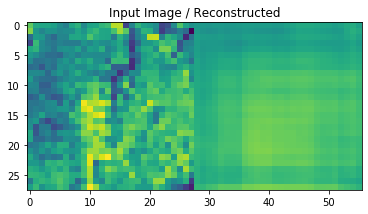

Index Image: 350  Reconstruction loss: 0.6666731 Discriminator Output: 0.3327989
Model Predicts: [array([[[[0.64243263],
         [0.71423066],
         [0.71428955],
         [0.72981656],
         [0.718512  ],
         [0.6983246 ],
         [0.6973923 ],
         [0.69203156],
         [0.7053563 ],
         [0.7016073 ],
         [0.7039852 ],
         [0.71765125],
         [0.7152966 ],
         [0.7120231 ],
         [0.71158564],
         [0.70791787],
         [0.70245063],
         [0.697228  ],
         [0.6938382 ],
         [0.682925  ],
         [0.66889465],
         [0.6511692 ],
         [0.644873  ],
         [0.6147814 ],
         [0.6236941 ],
         [0.6433552 ],
         [0.6543449 ],
         [0.61052155]],

        [[0.69521606],
         [0.7316884 ],
         [0.7329502 ],
         [0.7473704 ],
         [0.7538707 ],
         [0.7344261 ],
         [0.7325109 ],
         [0.7111133 ],
         [0.7231146 ],
         [0.71301997],
         [0.7165043 ],
   

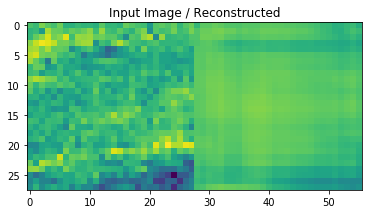

Index Image: 375  Reconstruction loss: 0.6778552 Discriminator Output: 0.33265832
Model Predicts: [array([[[[0.5612048 ],
         [0.56359696],
         [0.5605209 ],
         [0.5715465 ],
         [0.565762  ],
         [0.5526963 ],
         [0.55662644],
         [0.57315373],
         [0.5910419 ],
         [0.60570616],
         [0.5995997 ],
         [0.6020729 ],
         [0.5896513 ],
         [0.5691352 ],
         [0.56666136],
         [0.5554316 ],
         [0.55205   ],
         [0.54610753],
         [0.54532605],
         [0.53775793],
         [0.5210591 ],
         [0.49901724],
         [0.49142042],
         [0.46275985],
         [0.4696925 ],
         [0.4883494 ],
         [0.49998063],
         [0.47045922]],

        [[0.5699488 ],
         [0.54082566],
         [0.5335464 ],
         [0.54197395],
         [0.55618703],
         [0.54537475],
         [0.5532735 ],
         [0.5642016 ],
         [0.5919775 ],
         [0.6022954 ],
         [0.5942451 ],
  

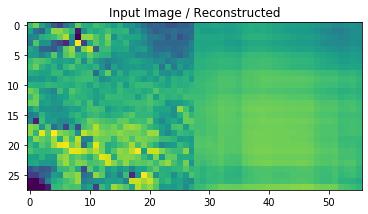

Index Image: 400  Reconstruction loss: 0.6081687 Discriminator Output: 0.4022111
Model Predicts: [array([[[[0.41690332],
         [0.3443082 ],
         [0.34529978],
         [0.34946167],
         [0.34858978],
         [0.35050297],
         [0.35180667],
         [0.35259914],
         [0.35299635],
         [0.34690624],
         [0.34628552],
         [0.3397738 ],
         [0.33408123],
         [0.32375956],
         [0.32102123],
         [0.31280795],
         [0.30866015],
         [0.3023337 ],
         [0.30095273],
         [0.29715857],
         [0.2926606 ],
         [0.28701437],
         [0.28450167],
         [0.27737635],
         [0.2699259 ],
         [0.25918493],
         [0.25559017],
         [0.27198327]],

        [[0.37450963],
         [0.2833255 ],
         [0.28502882],
         [0.29079992],
         [0.29078048],
         [0.29277042],
         [0.29364556],
         [0.28945976],
         [0.28906578],
         [0.28245914],
         [0.28186247],
   

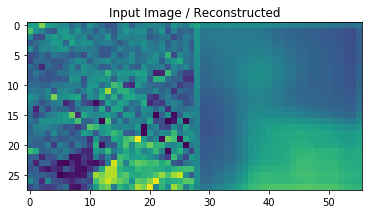

Index Image: 425  Reconstruction loss: 0.6939977 Discriminator Output: 0.36036906
Model Predicts: [array([[[[0.4945705 ],
         [0.46299732],
         [0.4611296 ],
         [0.46080437],
         [0.44730064],
         [0.4260926 ],
         [0.4265049 ],
         [0.42859334],
         [0.42882174],
         [0.42068994],
         [0.41690922],
         [0.4120018 ],
         [0.40443385],
         [0.39370066],
         [0.39206108],
         [0.38394248],
         [0.3780911 ],
         [0.37185076],
         [0.3713909 ],
         [0.36757243],
         [0.369812  ],
         [0.3736214 ],
         [0.3746001 ],
         [0.37547046],
         [0.3878746 ],
         [0.40720183],
         [0.41133067],
         [0.40382415]],

        [[0.48279166],
         [0.43187553],
         [0.43029708],
         [0.42564735],
         [0.40995276],
         [0.38908702],
         [0.38816878],
         [0.38287956],
         [0.3806144 ],
         [0.36396497],
         [0.3600805 ],
  

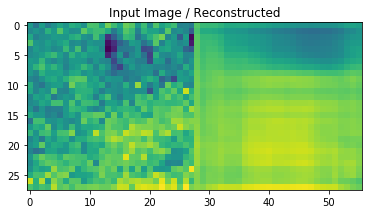

Index Image: 450  Reconstruction loss: 0.45487294 Discriminator Output: 0.3192136
Model Predicts: [array([[[[0.70669377],
         [0.7996048 ],
         [0.79931957],
         [0.8244437 ],
         [0.8211958 ],
         [0.8122446 ],
         [0.81218386],
         [0.8151293 ],
         [0.83045316],
         [0.83666223],
         [0.8386189 ],
         [0.84995055],
         [0.84655666],
         [0.8422542 ],
         [0.8428085 ],
         [0.84174323],
         [0.8426871 ],
         [0.84616566],
         [0.8430401 ],
         [0.8287411 ],
         [0.8120983 ],
         [0.79014397],
         [0.78308195],
         [0.74667037],
         [0.7506361 ],
         [0.76286197],
         [0.7668768 ],
         [0.6981653 ]],

        [[0.77095354],
         [0.8242874 ],
         [0.8236736 ],
         [0.8393639 ],
         [0.8522239 ],
         [0.8409796 ],
         [0.8403925 ],
         [0.8326764 ],
         [0.85147154],
         [0.85134083],
         [0.8541235 ],
  

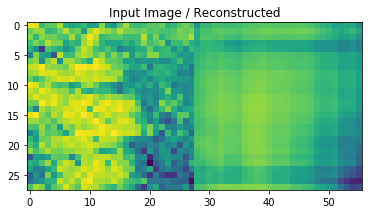

Index Image: 475  Reconstruction loss: 0.7054757 Discriminator Output: 0.35767806
Model Predicts: [array([[[[0.5496494 ],
         [0.55233365],
         [0.54970694],
         [0.55842453],
         [0.5529797 ],
         [0.5435299 ],
         [0.5449995 ],
         [0.5483994 ],
         [0.5585926 ],
         [0.56474316],
         [0.5625748 ],
         [0.56310105],
         [0.5491154 ],
         [0.53108364],
         [0.52691436],
         [0.5092786 ],
         [0.5015888 ],
         [0.48923156],
         [0.48991084],
         [0.4861871 ],
         [0.4766339 ],
         [0.46436298],
         [0.45722708],
         [0.4360365 ],
         [0.4367329 ],
         [0.4395095 ],
         [0.44217247],
         [0.42413935]],

        [[0.5606977 ],
         [0.5362294 ],
         [0.5303643 ],
         [0.5359166 ],
         [0.54375553],
         [0.53391594],
         [0.53616667],
         [0.53451943],
         [0.5461545 ],
         [0.5503046 ],
         [0.54899484],
  

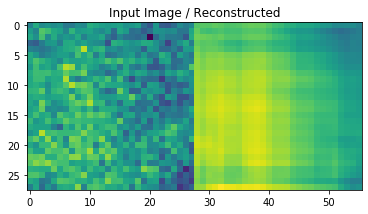

Index Image: 500  Reconstruction loss: 0.6588946 Discriminator Output: 0.3891851
Model Predicts: [array([[[[0.46532464],
         [0.40280658],
         [0.40197855],
         [0.388251  ],
         [0.3608858 ],
         [0.32847714],
         [0.32237017],
         [0.3116208 ],
         [0.2950536 ],
         [0.27186775],
         [0.26477915],
         [0.24013728],
         [0.24489844],
         [0.2521712 ],
         [0.2625451 ],
         [0.28911668],
         [0.30795717],
         [0.323744  ],
         [0.33041668],
         [0.36757886],
         [0.39074668],
         [0.42799795],
         [0.43791515],
         [0.45229423],
         [0.47716242],
         [0.5194805 ],
         [0.5264812 ],
         [0.50804853]],

        [[0.42744154],
         [0.34049666],
         [0.340856  ],
         [0.3190848 ],
         [0.28445715],
         [0.24153441],
         [0.23825452],
         [0.22022936],
         [0.2050542 ],
         [0.17700419],
         [0.1681191 ],
   

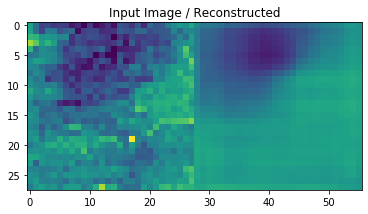

In [ ]:
for i in [25*i for i in range(1,50)]:
    test_reconstruction(i)


## Abnormal cases
The network was not trained on those labels, so the Generator/R network find it hard to reconstruct the input images reflected in higher reconstruction loss values.

Discriminator also outputs a lower value compared to normal ones.